### Analyses of motor behavior at profficiency
Jun2023 \
author: Inês Laranjeira

Analyses of different metrics, hypothesized to be stereotyped throughout learning.

Instructed movements:
- licking
- wheel movement

Uninstructed movements:
- gaze (uninstructed but likely related modulated by stimulus presentation)
- pupil size
- body movement
- whisking

In [1]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import re
from mpl_toolkits.mplot3d import Axes3D

from brainbox.task.trials import find_trial_ids
from brainbox.behavior.training import get_sessions, get_training_status
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from one.api import ONE

one = ONE()

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, KFold, cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get my functions
functions_path = "../Functions/"
os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro
from wheel_functions import stack_trials

## Get training data

In [3]:
# Get subjects of interest
subjects_of_interest = query_subjects_interest(protocol='ephys', ibl_project='ibl_neuropixel_brainwide_01')
#data = subjects_interest_data(subjects_of_interest)
data = subjects_interest_data(['KS016'], phase='proficient', protocol='ephys')

In [ ]:
'fa539f97-a078-4fc6-9a12-237799466d9c'

In [5]:
data.session.unique()

array(['16c3667b-e0ea-43fb-9ad4-8dcd1e6c40e1',
       'a08d3dcc-b8d1-4c22-834f-2a619c399bdf',
       '2d92ad3b-422c-445f-b2ca-4d74692dd7e5',
       'dd87e278-999d-478b-8cbd-b5bf92b84763',
       '6cf2a88a-515b-4f7f-89a2-7d53eab9b5f4'], dtype=object)

In [46]:
subjects_interest = query_subjects_interest(protocol='training', ibl_project='ibl_neuropixel_brainwide_01')
subjects_interest

array(['437', '438', '6725', '6814', 'CSHL034', 'CSHL045', 'CSHL046',
       'CSHL047', 'CSHL049', 'CSHL051', 'CSHL052', 'CSHL053', 'CSHL054',
       'CSHL055', 'CSHL056', 'CSHL057', 'CSHL058', 'CSHL059', 'CSHL060',
       'CSHL_001', 'CSHL_002', 'CSHL_003', 'CSHL_004', 'CSHL_005',
       'CSHL_006', 'CSHL_007', 'CSHL_008', 'CSHL_009', 'CSHL_010',
       'CSHL_011', 'CSHL_012', 'CSHL_013', 'CSHL_014', 'CSHL_015',
       'CSH_ZAD_001', 'CSH_ZAD_002', 'CSH_ZAD_003', 'CSH_ZAD_004',
       'CSH_ZAD_005', 'CSH_ZAD_006', 'CSH_ZAD_007', 'CSH_ZAD_009',
       'CSH_ZAD_010', 'CSH_ZAD_015', 'CSH_ZAD_016', 'CSH_ZAD_017',
       'CSH_ZAD_018', 'CSH_ZAD_019', 'CSH_ZAD_021', 'CSH_ZAD_022',
       'CSH_ZAD_023', 'CSH_ZAD_024', 'CSH_ZAD_025', 'CSH_ZAD_026',
       'CSH_ZAD_027', 'CSH_ZAD_028', 'CSH_ZAD_029', 'CSH_ZAD_030',
       'CSH_ZAD_031', 'CSH_ZAD_032', 'CSK-IBL-003', 'CSK-IBL-005',
       'DY_001', 'DY_002', 'DY_003', 'DY_005', 'DY_006', 'DY_007',
       'DY_008', 'DY_009', 'DY_010', 'DY_011', 

In [65]:
data = subjects_interest_data(['KS046'], phase='learning')
new_data = prepro(data)

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/aggregates/Subjects/cortexlab/KS046/_ibl_subjectTrials.table.434136f7-fa26-4058-9032-86d4ea0ac4c5.pqt: 100%|██████████| 2.75M/2.75M [00:01<00:00, 1.56MB/s]


In [66]:
perf = pd.DataFrame(new_data.groupby(['subject_nickname', 'session_start_time', 'session'])['correct_easy'].mean())
perf = perf.reset_index(level=[0, 1, 2])

In [67]:
perf

,subject_nickname,session_start_time,session,correct_easy
0,KS046,2020-10-07 07:42:35.353,72cb7d25-8b9a-4c48-a57c-b1fcb1307010,0.235457
1,KS046,2020-10-08 09:02:26.176,f6d9a472-94b9-4230-ac0d-055676c4b08a,0.163265
2,KS046,2020-10-09 07:48:48.981,8ff761db-13fc-4891-ab23-5f2c18ed134f,0.194751
3,KS046,2020-10-12 11:32:29.812,fb9c31e2-1fbe-40a0-aaab-dedffcbcd3c3,0.213425
4,KS046,2020-10-13 07:34:25.668,46b43809-478b-435d-b30a-bc51b63d53d1,0.240566
5,KS046,2020-10-14 08:35:49.059,055dbac4-f90d-404e-857a-26029bd5895f,0.217460
6,KS046,2020-10-15 08:55:38.632,482cfcbb-5e25-4819-af50-ef2134b857b3,0.383124
7,KS046,2020-10-16 07:29:36.246,baeca700-438a-43c5-bfa0-b11536a37fdb,0.649864
8,KS046,2020-10-19 08:35:14.512,3361857d-36fd-431f-9c79-58e62bfaaece,0.686901
9,KS046,2020-10-20 17:43:06.623,ce2ce78b-5778-408b-aa3e-6f76e34790e1,0.822188


<AxesSubplot: xlabel='session_start_time', ylabel='correct_easy'>

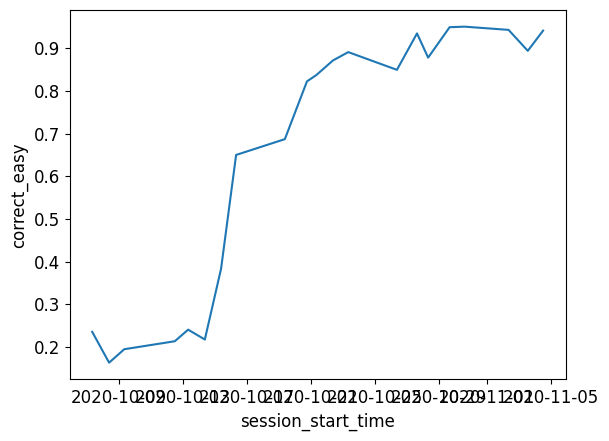

In [68]:
sns.lineplot(x='session_start_time', y='correct_easy', data=perf)

## Naive sessions

## Load wheel data

In [35]:

def wheel_interval(t_init, t_end, interval_length, sessions):

    all_wheel = pd.DataFrame()
    # Loop through sessions (could put this inside an animal loop)
    for s, session in enumerate(sessions):
        # Get session data
        eid = session
        wheel = one.load_object(eid, 'wheel', collection='alf')
        wheelMoves = one.load_object(eid, 'wheelMoves', collection='alf')
        trials_data = data.loc[data['session']==eid][0:50]
        processed_data = prepro(trials_data)

        # Get wheel data for that session
        pos, time = wh.interpolate_position(wheel.timestamps, wheel.position)

        wheel_stack = pd.DataFrame(stack_trials(time=time, position=pos, trials=processed_data, event='stimOn_times', t_init=t_init, t_end=t_end, interval_length=interval_length))
        
        if s == 0:
            all_wheel = wheel_stack.copy()
            #all_wheel['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
            #all_wheel['session_number'] = s + 1
            all_wheel['feedback'] = list(processed_data['correct'])
            all_wheel['choice'] = list(processed_data['choice'])
            all_wheel['contrast'] = list(processed_data['contrast'])
            all_wheel['side'] = list(np.sign(processed_data['signed_contrast']))
        else:
            #wheel_stack['mouse_name'] = 'KS014'  #TODO: make this not hard-coded
            #wheel_stack['session_number'] = s + 1
            wheel_stack['feedback'] = list(processed_data['correct'])
            wheel_stack['choice'] = list(processed_data['choice'])
            wheel_stack['contrast'] = list(processed_data['contrast'])
            wheel_stack['side'] = list(np.sign(processed_data['signed_contrast']))
            all_wheel = all_wheel.append(wheel_stack)
        
        return all_wheel


## Plot wheel movements

In [43]:
t_init = 1  # time to plot before stimulus onset
t_end = 1.5 # time to plot after stimulus onset
interval_length = int((t_end + t_init) * 1000)

### Plot per stimulus side 

In [40]:
threshold_deg = 35
gain = 4
threshold_rad = wh.cm_to_rad(1e-1) * (threshold_deg / gain)

### Proficient session

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-11-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 2.50M/2.50M [00:01<00:00, 1.52MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-11-04/001/alf/_ibl_wheel.position.npy: 100%|██████████| 2.50M/2.50M [00:01<00:00, 2.33MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-11-04/001/alf/_ibl_wheelMoves.peakAmplitude.npy: 100%|██████████| 17.3k/17.3k [00:00<00:00, 47.2kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-11-04/001/alf/_ibl_wheelMoves.intervals.npy: 100%|██████████| 34.5k/34.5k [00:00<00:00, 66.3kB/s]


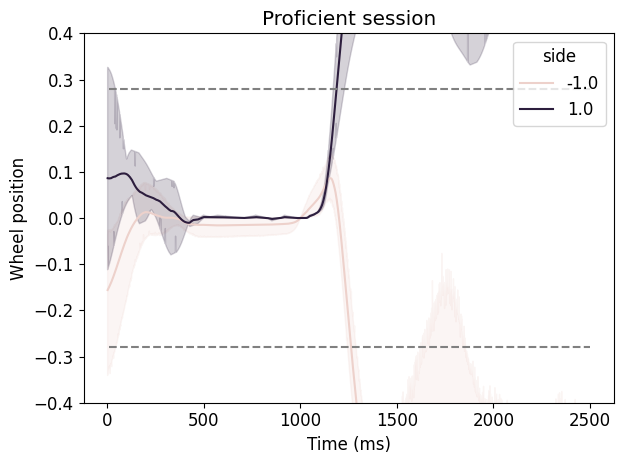

In [69]:

sessions = ['488c2722-75af-4ff0-b09b-ba7e4cc11890']  # proficient session
sessions = ['f25c12a9-ea24-4c13-9dab-f198d8bec81f']
all_wheel = wheel_interval(t_init, t_end, interval_length, sessions)
melted = pd.melt(all_wheel, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(all_wheel.keys()[1:-4]))
new_melted = melted.loc[melted['contrast']>0.4]
plt.rc('font', size=12)

sns.lineplot(x='variable', y='value', hue='side', data=new_melted)
plt.xlabel('Time (ms)')
plt.ylabel('Wheel position')
plt.ylim([-.4, .4])
plt.title('Proficient session')
plt.hlines(0.28, 9, 2500, color='grey', linestyles='dashed')
plt.hlines(-0.28, 9, 2500, color='grey', linestyles='dashed')
plt.tight_layout()

### Naif session

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-10-07/001/alf/_ibl_wheel.position.npy: 100%|██████████| 1.19M/1.19M [00:02<00:00, 533kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-10-07/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 1.19M/1.19M [00:00<00:00, 1.85MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-10-07/001/alf/_ibl_wheelMoves.peakAmplitude.npy: 100%|██████████| 7.22k/7.22k [00:00<00:00, 21.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-10-07/001/alf/_ibl_wheelMoves.intervals.npy: 100%|██████████| 14.3k/14.3k [00:00<00:00, 45.2kB/s]


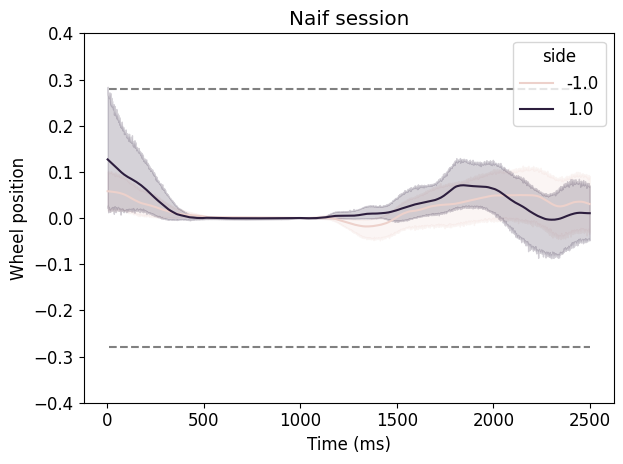

In [70]:
sessions = ['72cb7d25-8b9a-4c48-a57c-b1fcb1307010']  # naif session
all_wheel = wheel_interval(t_init, t_end, interval_length, sessions)
melted = pd.melt(all_wheel, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(all_wheel.keys()[1:-4]))

plt.rc('font', size=12)

sns.lineplot(x='variable', y='value', hue='side', data=melted)
plt.xlabel('Time (ms)')
plt.ylabel('Wheel position')
plt.ylim([-.4, .4])
plt.title('Naif session')
plt.hlines(0.28, 9, 2500, color='grey', linestyles='dashed')
plt.hlines(-0.28, 9, 2500, color='grey', linestyles='dashed')

plt.tight_layout()

### Plot per contrast, choice, and feedback

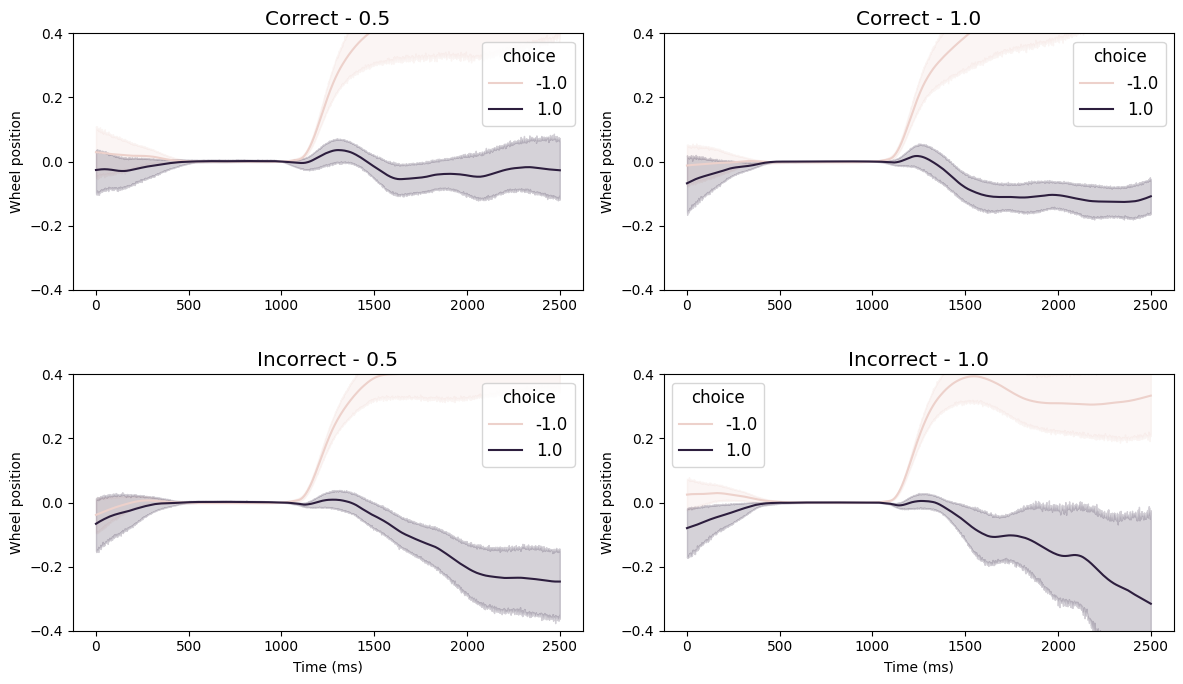

In [13]:
contrasts = melted.contrast.unique()
contrasts.sort()

fig, ax = plt.subplots(nrows=2, ncols=len(contrasts), sharex=False, sharey=False, figsize=[12, 7])

plt.rc('font', size=12)

for c, contrast in enumerate(contrasts):
    
    data_correct = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==1.0)]
    data_incorrect = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==0.0)]

    sns.lineplot(x='variable', y='value', hue='choice', data=data_correct, ax = ax[0, c])
    sns.lineplot(x='variable', y='value', hue='choice', data=data_incorrect, ax = ax[1, c])

    ax[0,c].set_xlabel(' ')
    ax[1,c].set_xlabel('Time (ms)')
    ax[0,c].set_ylabel('Wheel position')
    ax[1,c].set_ylabel('Wheel position')
    ax[0, c].set_ylim([-.4, .4])
    ax[1, c].set_ylim([-.4, .4])

    ax[0,c].set_title(str('Correct - ' + str(contrast)))
    ax[1,c].set_title(str('Incorrect - ' + str(contrast)))

plt.tight_layout()